<a href="https://colab.research.google.com/github/Anish03112003/RAG_Model_Evaluation/blob/main/RAG_Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we aim to evaluate the quality of answers/responses in an RAG pipeline or for an LLM using both semantic and keyword similarity measures. The evaluation involves calculating scores based on different similarity metrics and combining them to derive a final score for the answers. We will leverage pre-trained language models for semantic analysis and traditional NLP techniques for keyword or token similarity.

## What are we doing?

We are developing a system to evaluate the quality of answers by comparing them with ground truth answers and the provided context. The evaluation involves:
1. **Calculating semantic similarity**: Using BERT embeddings and a question generation pipeline to assess how well the answers relate to the original context and ground truth.
2. **Calculating keyword similarity**: Using traditional NLP techniques such as Jaccard similarity, TF-IDF cosine similarity, keyword matching, and edit distance to measure the similarity between texts.
3. **Combining scores**: Integrating both semantic and keyword similarity scores to derive a comprehensive evaluation metric. Since we need both similarities independently, we are multiplyng them both.

## Why are we doing this?

Evaluating the quality of answers is crucial in various applications, such as automated customer support, educational tools, and AI-driven information retrieval systems. By combining both semantic and keyword similarity measures, we can achieve a more robust and nuanced assessment of answer correctness, accounting for both contextual relevance and surface-level text similarities.

## How are we doing this?

We implement this evaluation system using a structured and modular approach, adhering to the SOLID principles of software design. We are using multiple metrices for calculating keyword matchinghence Keyword similarity and hybrid similarity are used interchangeably. The project is divided into several classes, each responsible for specific tasks:

1. **DataHandler Class**: Manages data loading from files.
2. **SemanticScorer Class**: Calculates semantic similarity scores using BERT embeddings and a question generation pipeline.
3. **HybridScorer Class**: Computes hybrid similarity scores using traditional NLP techniques.
4. **Evaluator Class**: Integrates the functionalities of the above classes to compute final evaluation scores.
5. **Plotter Class**: Visualizes the evaluation results (optional).


## Prerequisites

Before using these modules, ensure you have the following:

- `spacy`: Install using `pip install spacy`. Also, download the English model with `python -m spacy download en`. v3.7.5
- `transformers`: Install using `pip install transformers`. v4.41.2
- `torch`: Install using `pip install torch`. v2.2.1
- `sklearn`: Install using `pip install scikit-learn`.
- `nltk`: Install using `pip install nltk`. v3.8.1
Additionally, download NLTK data with:
  ```python
  import nltk
  nltk.download('punkt')
  nltk.download('stopwords')


In [ ]:
!pip install spacy
!python -m spacy download en
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install nltk

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 105.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
import spacy
from transformers import BertTokenizer, BertModel, pipeline
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.metrics.distance import edit_distance
import numpy as np
import matplotlib.pyplot as plt
import nltk

# must download if not already downloaded
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### DataHandler Class

The `DataHandler` class is all about making sure we can easily read and manage our data. It handles loading the question, answer, context, and ground truth from text files. By putting this responsibility into one class, we keep our data organized and ensure that if we ever need to change how we handle data, we only have to update it in one place. This approach keeps our code clean and easy to maintain.

In [ ]:
class DataHandler:
    def __init__(self, file_prefix):
        self.question = self.load_file(f'question{file_prefix}.txt')
        self.answer = self.load_file(f'answer{file_prefix}.txt')
        self.context = self.load_file(f'context{file_prefix}.txt')
        self.ground_truth = self.load_file(f'groundtruth{file_prefix}.txt')

    def load_file(self, filename):
        with open(filename, 'r') as file:
            return file.read().strip()

### SemanticScorer Class

The `SemanticScorer` class is where the heavy lifting for understanding text happens. Using pre-trained BERT embeddings and a question generation pipeline, it calculates how relevant, correct, and contextually appropriate an answer is. This class digs deep into the meaning of the text, providing a nuanced measure of answer quality. By keeping semantic scoring in its own class, we keep our code modular and focused, making it easier to manage and extend.

In [ ]:
class SemanticScorer:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.question_generator = pipeline('text2text-generation', model='t5-base', tokenizer='t5-base', device = 0)

    def get_sentence_embedding(self, sentence):
        inputs = self.tokenizer(sentence, return_tensors='pt', truncation=True, padding=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze()

    def generate_questions(self, answer, num_questions=3):
        questions = []
        for _ in range(num_questions):
            generated = self.question_generator(f"generate question: {answer}", max_length=50, num_return_sequences=1)
            questions.append(generated[0]['generated_text'])
        return questions

    def calculate_answer_relevancy(self, question, answer, num_questions=3):
        original_question_embedding = self.get_sentence_embedding(question)
        generated_questions = self.generate_questions(answer, num_questions)

        cosine_similarities = []
        for gen_question in generated_questions:
            gen_question_embedding = self.get_sentence_embedding(gen_question)
            similarity = cosine_similarity(original_question_embedding.unsqueeze(0), gen_question_embedding.unsqueeze(0))[0][0]
            cosine_similarities.append(similarity)

        answer_relevancy = sum(cosine_similarities) / num_questions
        return answer_relevancy

    def calculate_scores(self, question, answer, context, ground_truth):
        relevancy = self.calculate_answer_relevancy(question, answer)
        answer_embedding = self.get_sentence_embedding(answer)
        ground_truth_embedding = self.get_sentence_embedding(ground_truth)
        correctness = cosine_similarity(answer_embedding.unsqueeze(0), ground_truth_embedding.unsqueeze(0))[0][0]

        if context:
            context_embedding = self.get_sentence_embedding(context)
            meaning = cosine_similarity(answer_embedding.unsqueeze(0), context_embedding.unsqueeze(0))[0][0]
        else:
            meaning = 0.0

        return relevancy, correctness, meaning

    def calculate_final_score(self, relevancy, correctness, meaning, context):
        if context:
            final_score = 0.70 * correctness + 0.15 * meaning + 0.15 * relevancy
        else:
            final_score = 0.75 * correctness + 0.25 * relevancy
        return final_score

### HybridScorer Class

The `KeywordScorer` class handles the surface-level text analysis. It calculates keyword similarity using methods like Jaccard similarity, TF-IDF cosine similarity, keyword matching, and edit distance. These methods focus on the text's basic features, offering a different angle from the deep semantic analysis. By combining various similarity metrics, this class provides a comprehensive look at textual similarity. Isolating this functionality into a single class makes it easier to tweak or expand these scoring methods in the future.

In [ ]:
class HybridScorer:
    def __init__(self):
        pass

    def preprocess(self, text):
        tokens = word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
        return filtered_tokens

    def jaccard_similarity(self, str1, str2):
        tokens1 = set(self.preprocess(str1))
        tokens2 = set(self.preprocess(str2))
        intersection = tokens1.intersection(tokens2)
        union = tokens1.union(tokens2)
        if not union:  # Both sets are empty
            return 1.0 if not tokens1 and not tokens2 else 0.0
        return len(intersection) / len(union)

    def cosine_similarity_tfidf(self, str1, str2):
        vectorizer = TfidfVectorizer().fit_transform([str1, str2])
        vectors = vectorizer.toarray()
        return cosine_similarity(vectors)[0, 1]

    def keyword_match_score(self, str1, str2):
        tokens1 = self.preprocess(str1)
        tokens2 = self.preprocess(str2)
        matches = sum(1 for token in tokens1 if token in tokens2)
        return matches / max(len(tokens1), len(tokens2))

    def edit_distance_score(self, str1, str2):
        return 1 - (edit_distance(str1, str2) / max(len(str1), len(str2)))

    def calculate_hybrid_score(self, str1, str2):
        jaccard = self.jaccard_similarity(str1, str2)
        cosine_tfidf = self.cosine_similarity_tfidf(str1, str2)
        keyword_match = self.keyword_match_score(str1, str2)
        edit_dist = self.edit_distance_score(str1, str2)

        hybrid_score = 0.25 * jaccard + 0.25 * cosine_tfidf + 0.25 * keyword_match + 0.25 * edit_dist
        return hybrid_score

### Evaluator Class

The `Evaluator` class is the orchestrator of the whole process. It uses the `DataHandler` to get the data and then leverages the `SemanticScorer` and `KeywordScorer` to compute the final scores. This class brings together all the different parts, calculating both semantic and keyword similarity scores to give a thorough evaluation of answer quality. By centralizing the evaluation logic here, we ensure our approach is systematic and easy to manage.

In [ ]:
class Evaluator:
    def __init__(self, data_handler, semantic_scorer, hybrid_scorer):
        self.data_handler = data_handler
        self.semantic_scorer = semantic_scorer
        self.hybrid_scorer = hybrid_scorer

    def evaluate(self):
        question = self.data_handler.question
        answer = self.data_handler.answer
        context = self.data_handler.context
        ground_truth = self.data_handler.ground_truth

        relevancy, correctness, meaning = self.semantic_scorer.calculate_scores(question, answer, context, ground_truth)
        final_score_semantic = self.semantic_scorer.calculate_final_score(relevancy, correctness, meaning, context)

        if context:
            final_score_hybrid = 0.90 * self.hybrid_scorer.calculate_hybrid_score(answer, ground_truth) + 0.10 * self.hybrid_scorer.calculate_hybrid_score(answer, context)
        else:
            final_score_hybrid = self.hybrid_scorer.calculate_hybrid_score(answer, ground_truth)

        final_score_combined = final_score_semantic * final_score_hybrid

        return final_score_hybrid, final_score_semantic, final_score_combined

### Plotter Class

The `Plotter` class takes care of visualizing our results. It creates graphs that show the final semantic, keyword, and combined scores for different examples, making it easy to see how well each answer performs. By putting all the plotting functionality in one class, we keep our evaluation logic uncluttered and maintain a clear separation of concerns. This way, the visualization part of our project remains flexible and easy to update.

In [ ]:
class Plotter:
    @staticmethod
    def plot_results(results):
        ex_labels, final_hybrid_scores, final_semantic_scores, final_combined_scores = zip(*results)

        plt.figure(figsize=(12, 8))

        plt.plot(ex_labels, final_semantic_scores, label='Final Semantic Score', color='blue')
        plt.plot(ex_labels, final_hybrid_scores, label='Final Token Score', color='green')
        plt.plot(ex_labels, final_combined_scores, label='Final Combined Score', color='red', linewidth=3)

        plt.xlabel('Examples')
        plt.ylabel('Scores')
        plt.title('Scores of Different Examples')
        plt.xticks(rotation=45, ha='right')
        # plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
        plt.legend()
        plt.show()

# Tried Examples

1. EX1: Focuses on the benefits of machine learning in healthcare—improving diagnostics, enabling personalized treatment, and aiding in medical imaging.
2. EX2: Explores the differences between deep learning and traditional machine learning, highlighting how deep learning automates feature learning through neural networks.
3. EX3: Discusses the ethical concerns of AI in decision-making, including potential biases, privacy impacts, and transparency issues.
4. EX4: Compares supervised and unsupervised learning approaches, emphasizing the use of labeled data in supervised learning versus pattern discovery without labels in unsupervised learning.
5. EX5: Describes the importance of data preprocessing in machine learning, covering how data cleaning and normalization enhance model accuracy and robustness.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


EX1 - Final Token Score: 21.38, Final Semantic Score: 74.33999999999999, Final Combined Score: 15.9


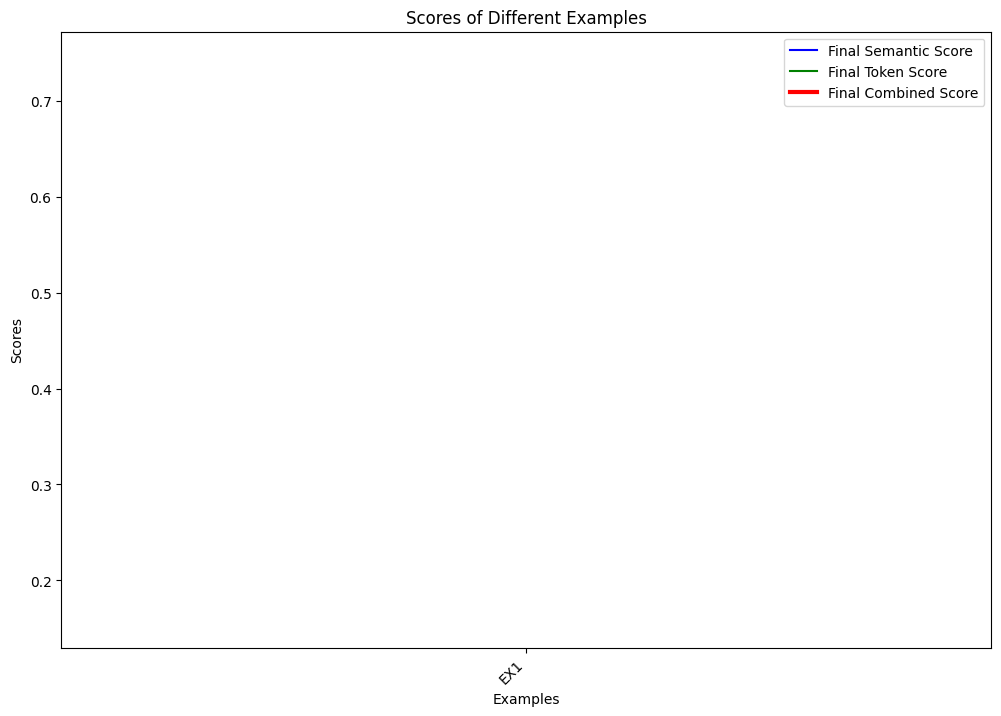

In [ ]:
# Main execution
results = []
for ex in ['EX1', 'EX2', 'EX3', 'EX4', 'EX5']:
    data_handler = DataHandler(ex)
    semantic_scorer = SemanticScorer()
    hybrid_scorer = HybridScorer()
    evaluator = Evaluator(data_handler, semantic_scorer, hybrid_scorer)
    final_score_hybrid, final_score_semantic, final_score_combined = evaluator.evaluate()
    results.append((ex, final_score_hybrid, final_score_semantic, final_score_combined))
    print(f"{ex} - Final Token Score: {round(final_score_hybrid,4) * 100}, Final Semantic Score: {round(final_score_semantic,4) * 100}, Final Combined Score: {round(final_score_combined,4) * 100}")

Plotter.plot_results(results)